<a href="https://colab.research.google.com/github/AvikantSrivastava/Dog-Breed-Identification-Mobile-App/blob/master/dog_breed_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
tf.__version__

'2.3.0'

In [ ]:
import PIL
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image as Image1


In [ ]:
data = tfds.builder('stanford_dogs')


In [ ]:
# getting class labels
# !wget http://vision.stanford.edu/aditya86/ImageNetDogs/lists.tar
!tar -xf lists.tar 

In [ ]:
get_name = data.info.features['label'].int2str

In [ ]:
get_name(0)

'n02085620-chihuahua'

In [ ]:
names = []

for i in range(120):
  name = get_name(i)
  names.append(name)

In [ ]:
with open('your_file.txt', 'w') as f:
    for name in names:
        f.write("%s\n" % name)

In [ ]:
w to convet print(
    # data.info.features['image'].shape,
data.info.features['label'].shape)
# data.info.features['train'].shape

()


In [ ]:
data.download_and_prepare()

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteR4AMZR/stanford_dogs-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteR4AMZR/stanford_dogs-test.tfrecord


ERROR:absl:Statistics generation doesn't work for nested structures yet


ERROR:absl:Statistics generation doesn't work for nested structures yet



Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


In [ ]:
dataset = data.as_dataset()

In [ ]:
train_dataset, test_dataset = dataset['train'], dataset['test']


In [ ]:
def get_images(features):
    image = features['image']
    image = tf.image.resize(
        image, (), 
        method=ResizeMethod.BILINEAR, 
        preserve_aspect_ratio=False)
    return image

def get_labels(features):
    # print(features['label'])
    one_hotted = tf.one_hot(features['label'], 120)
    return one_hotted

def get_data(features):
    # print(features['label'])
    one_hotted = tf.one_hot(features['label'], 120)
    image = features['image']
    image = tf.image.resize(
        image, [224,224], 
        # method=ResizeMethod.BILINEAR, 
        preserve_aspect_ratio=False)
    return image,one_hotted


In [ ]:
for example in train_dataset.take(1):  # Only take a single example
  image, label = example["image"], example["label"]
  print(label)


tf.Tensor(36, shape=(), dtype=int64)


In [ ]:
x_train = train_dataset.map(get_images).batch(32)
y_train = train_dataset.map(get_labels).batch(32)

NameError: ignored

In [ ]:
train_data = train_dataset.map(get_data).batch(64)

In [ ]:
test_data = test_dataset.map(get_data).batch(64)

In [ ]:
train_data

<DatasetV1Adapter shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.float32)>

In [ ]:
mobile_net_base_model =  tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3), alpha=1.0, include_top=0, weights='imagenet',
     classes= 120 , classifier_activation='softmax')

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
mobile_net_base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [ ]:
mobile_net_base_model.trainable = False

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
# this will ensure that the images are in [-1,1] range

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
# GAP layer after the base model

In [ ]:
softmax = tf.keras.layers.Softmax(
    axis=-1
)

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])
# for data augmentation

In [ ]:
# stitching the model
inputs = tf.keras.Input(shape = (224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
# x = tf.keras.layers.Reshape((None, None , None , 3))(x)
x = mobile_net_base_model(x)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(120, activation='softmax')(x)  
# outputs = softmax(x)
model = tf.keras.Model(inputs, outputs)








In [ ]:
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
tf_op_layer_RealDiv (TensorF [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub (TensorFlowO [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)             

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', verbose = True, patience = 5
)



In [ ]:
BATCH_SIZE=64
EPOCHS=50

# data = tf.keras.layers.Reshape(
#     (None,None,None 3) )

history = model.fit(
    train_data, 
    
    batch_size=BATCH_SIZE, 
    epochs=1, verbose=1, 
    # validation_split = 0.2,
    validation_data = test_data,
    callbacks = callback

)

188/188 [==============================] - 55s 295ms/step - loss: 0.6068 - accuracy: 0.8075 - val_loss: 0.6043 - val_accuracy: 0.8143


In [ ]:
model.evaluate(test_data)

135/135 [==============================] - 21s 153ms/step - loss: 0.6043 - accuracy: 0.8143


[0.6043247580528259, 0.8143356442451477]

In [ ]:

def final_process(path):
  img = Image.open(path).convert("L")
  model = imported_model
  pil_img = Image1(filename=path)
  display(pil_img)

  img = np.resize(img, (224,224,3))
  im2arr = np.array(img)
  im2arr = im2arr.reshape(1,224,224,3)
  y_pred = model.predict(im2arr)
  probabilities = tf.nn.softmax(y_pred)
  predicted_indices = tf.argmax(probabilities, 1)
  # predicted_class = tf.gather(TARGET_LABELS, predicted_indices)
  name = get_name(tf.cast(predicted_indices[0] , tf.int32))

  print(name)

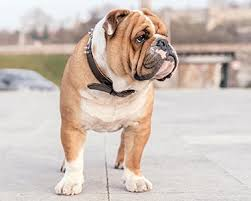

n02108915-french_bulldog


In [ ]:
final_process('bulldog.jpeg')

In [ ]:
def upload_files(message):
  print(message)
  from google.colab import files
  uploaded = files.upload()
  for k, v in uploaded.items():
    open(k, 'wb').write(v)


  path = uploaded.keys()
  print(path)
  final_process(path)



  # path_list = list(uploaded.keys())

  # for path in path_list:
  #     final_process(path_list)

In [ ]:
upload_files('Upload a dog picture')

Upload a dog picture


Saving bulldog.jpeg to bulldog.jpeg
dict_keys(['bulldog.jpeg'])


AttributeError: ignored

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
model.save('dog_model.h5')

In [ ]:
!cp /content/drive/My\ Drive/dog_model.h5 dog_model.h5

In [ ]:
imported_model = tf.keras.models.load_model('dog_model.h5')


In [ ]:
imported_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
tf_op_layer_RealDiv (TensorF (None, 224, 224, 3)       0         
_________________________________________________________________
tf_op_layer_Sub (TensorFlowO (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)             

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(imported_model)
tflite_model = converter.convert()


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


INFO:tensorflow:Assets written to: /tmp/tmpc6aunngm/assets


INFO:tensorflow:Assets written to: /tmp/tmpc6aunngm/assets


In [ ]:
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)